In [149]:
!pip install lifelines

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 

from scipy.stats import ttest_ind, chi2_contingency, f_oneway, pearsonr, spearmanr
from sklearn.preprocessing import LabelEncoder
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [151]:
data = pd.read_csv("/kaggle/input/marketing-ab-testing/marketing_AB.csv")

In [152]:
# Display the first few rows
print(data.head())

# Check for missing values and data types
print(data.info())
print(data.isnull().sum())

   Unnamed: 0  user id test group  converted  total ads most ads day  \
0           0  1069124         ad      False        130       Monday   
1           1  1119715         ad      False         93      Tuesday   
2           2  1144181         ad      False         21      Tuesday   
3           3  1435133         ad      False        355      Tuesday   
4           4  1015700         ad      False        276       Friday   

   most ads hour  
0             20  
1             22  
2             18  
3             10  
4             14  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null

In [153]:
# Drop unnecessary columns
data.drop(["Unnamed: 0", "user id"], axis=1, inplace=True)

# Rename columns 
data.rename(columns={'test group': 'test_group', 
                     'total ads': 'total_ads', 
                     'most ads day': 'most_ads_day', 
                     'most ads hour': 'most_ads_hour'}, inplace=True)

# Convert 'converted' to integer 
data['converted'] = data['converted'].astype(int)

# Summary statistics
print("Summary Statistics for Numerical Variables:")
print(data.describe())

# Group counts for 'test_group'
print("\nCounts by Test Group:")
print(data['test_group'].value_counts())

# Check conversion rates
print("\nConversion Rates by Test Group:")
print(data.groupby('test_group')['converted'].mean())

Summary Statistics for Numerical Variables:
           converted      total_ads  most_ads_hour
count  588101.000000  588101.000000  588101.000000
mean        0.025239      24.820876      14.469061
std         0.156850      43.715181       4.834634
min         0.000000       1.000000       0.000000
25%         0.000000       4.000000      11.000000
50%         0.000000      13.000000      14.000000
75%         0.000000      27.000000      18.000000
max         1.000000    2065.000000      23.000000

Counts by Test Group:
test_group
ad     564577
psa     23524
Name: count, dtype: int64

Conversion Rates by Test Group:
test_group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64


### Interpretation:

- converted: The converted column has a mean of 0.0252, suggesting that 2.52% of users in the dataset converted.

- total_ads: The total_ads column has an average of approximately 24.82 ads shown per user, with a wide range from 1 to 2065 ads.

- most_ads_hour: The average hour with the most ads shown is around 14:28 (in a 24-hour scale), with values ranging from 0 to 23.

- There are 564,577 entries in the ad group and 23,524 entries in the psa group.

- The dataset is heavily skewed towards the ad group.

- The conversion rate for the ad group is 2.55%, while the conversion rate for the psa group is 1.79%.

- The ad group has a higher conversion rate compared to the psa group, which might suggest better performance or appeal of ads over public service announcements.

# T-Test:

Compare the conversion rates between the ad group and the psa group.

In [154]:
# Split data into groups
ad_group = data[data['test_group'] == 'ad']['converted']
psa_group = data[data['test_group'] == 'psa']['converted']

# Perform T-Test
t_stat, p_value = ttest_ind(ad_group, psa_group, equal_var=False)

print("\nT-Test Results:")
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4e}")


T-Test Results:
T-Statistic: 8.6572
P-Value: 5.1076e-18


### T-Test Results Interpretation

#### **Test Summary**
- **T-Statistic**: 8.6572
- **P-Value**: 5.1076e-18

#### **What the T-Test Measures?**
The T-Test compares the means of two independent groups—in this case, the **ad group** (users who saw advertisements) and the **psa group** (users who saw public service announcements). The null hypothesis H0 assumes there is no difference in conversion rates between the two groups.

#### **Interpretation**
- **T-Statistic**: A t-statistic of 8.6572 indicates a significant difference between the means of the two groups.
- **P-Value**: The p-value (5.1076e-18) is extremely small and well below the conventional significance level α=0.05. This provides strong evidence to reject the null hypothesis H0.

#### **Conclusion**
The test results suggest that the **ad group** and **psa group** have significantly different conversion rates. Since the t-statistic is positive, it indicates that the **ad group** has a higher conversion rate compared to the **psa group**.

# Cohen's 𝑑 for T-Test

Cohen's 𝑑 quantifies the effect size for the difference between two means. It is calculated as: 𝑑 = (mean difference) / (pooled standard deviation).

In [155]:
# Calculate Cohen's d for the t-test
mean_diff = ad_group.mean() - psa_group.mean()
pooled_std = np.sqrt(((ad_group.var() * (len(ad_group) - 1)) + 
                      (psa_group.var() * (len(psa_group) - 1))) / 
                     (len(ad_group) + len(psa_group) - 2))
cohen_d = mean_diff / pooled_std

print("\nEffect Size (Cohen's d):")
print(f"Cohen's d: {cohen_d:.4f}")


Effect Size (Cohen's d):
Cohen's d: 0.0490


### Effect Size (Cohen's d) Interpretation

#### **Test Summary**
- **Effect Size (Cohen's d)**: 0.0490

#### **What Cohen's d Measures?**
Cohen's d quantifies the size of the difference between two group means relative to the pooled standard deviation. It is a standardized effect size that helps determine the practical significance of the difference.

#### **Interpretation**
- **Effect Size Value**: A Cohen's d of 0.0490 suggests a very small effect size. According to conventional thresholds:
  - Small effect: d=0.2d = 0.2
  - Medium effect: d=0.5d = 0.5
  - Large effect: d=0.8d = 0.8
- A d of 0.0490 indicates that the difference between the **ad group** and **psa group** is negligible in practical terms, even if the statistical test might have shown significance.

#### **Conclusion**
The observed difference between the **ad group** and **psa group** is statistically significant (if shown by the t-test), but the effect size is minimal. This suggests that while the difference is real, its practical importance is very limited.

# ANOVA:

 Analyze total_ads across multiple days (most_ads_day).

In [156]:
# Perform ANOVA for total ads across days
anova_groups = [data[data['most_ads_day'] == day]['total_ads'] for day in data['most_ads_day'].unique()]
f_stat, p_value_anova = f_oneway(*anova_groups)

print("\nANOVA Results:")
print(f"F-Statistic: {f_stat:.4f}")
print(f"P-Value: {p_value_anova:.4e}")


ANOVA Results:
F-Statistic: 50.3731
P-Value: 2.8155e-62


### ANOVA Results Interpretation

#### **Test Summary**
- **F-Statistic**: 50.3731
- **P-Value**: 2.8155e-62

#### **What ANOVA Measures?**
Analysis of Variance (ANOVA) tests whether there are statistically significant differences in the means of **total ads shown** across different days of the week (e.g., Monday, Tuesday, etc.). The null hypothesis H0 assumes that the mean number of ads shown is the same across all days.

#### **Interpretation**
- **F-Statistic**: A high F-statistic of 50.3731 indicates a strong variation in the total ads shown across days.
- **P-Value**: The extremely small p-value (2.8155e-62) is far below the significance threshold α=0.05, providing very strong evidence to reject the null hypothesis H0.

#### **Conclusion**
The ANOVA results indicate that there are significant differences in the number of ads shown across different days of the week. This means the day of the week significantly impacts how many ads users are exposed to.

#### **Implications**
This finding suggests that ad distribution patterns vary throughout the week, which could be due to user activity levels, campaign targeting, or scheduling preferences. Marketing strategies could be adjusted to focus on high-performing days to maximize impact. Further post-hoc tests (e.g., Tukey's test) can be conducted to identify which specific days differ significantly.

## Tukey's HSD Test:

**Tukey's Honest Significant Difference (HSD) Test** is a post-hoc test used after an ANOVA to determine which specific groups' means are significantly different from each other. 

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
  Friday    Monday  -1.2836    0.0 -1.8919 -0.6754   True
  Friday  Saturday  -1.3845    0.0  -2.003 -0.7659   True
  Friday    Sunday  -2.2085    0.0 -2.8198 -1.5971   True
  Friday  Thursday  -3.1833    0.0 -3.7992 -2.5673   True
  Friday   Tuesday  -2.6867    0.0  -3.314 -2.0593   True
  Friday Wednesday  -2.0729    0.0  -2.693 -1.4528   True
  Monday  Saturday  -0.1009 0.9992 -0.7286  0.5268  False
  Monday    Sunday  -0.9249 0.0002 -1.5454 -0.3043   True
  Monday  Thursday  -1.8997    0.0 -2.5248 -1.2746   True
  Monday   Tuesday  -1.4031    0.0 -2.0394 -0.7667   True
  Monday Wednesday  -0.7893 0.0041 -1.4185 -0.1601   True
Saturday    Sunday   -0.824 0.0023 -1.4547 -0.1933   True
Saturday  Thursday  -1.7988    0.0  -2.434 -1.1637   True
Saturday   Tuesday  -1.3022    0.0 -1.9484  -0.656   True
Saturday Wedne

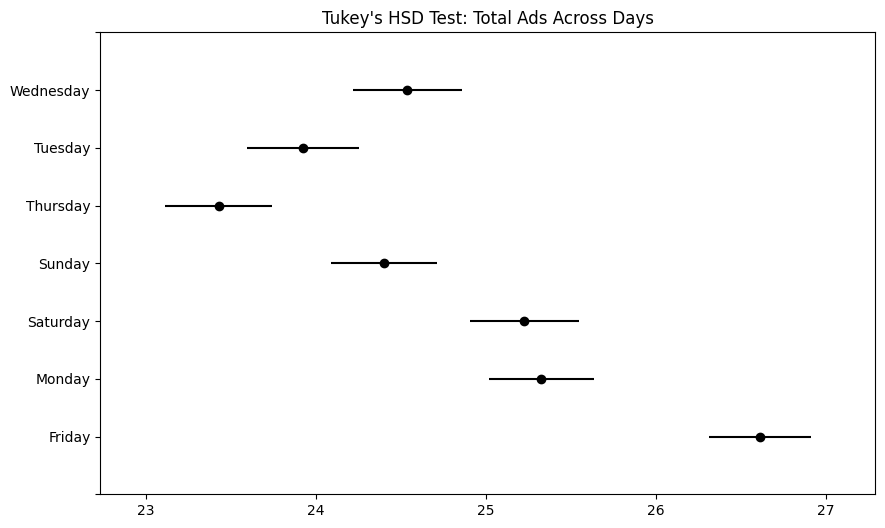

In [157]:
# Tukey's HSD Test
tukey = pairwise_tukeyhsd(endog=data['total_ads'],  # The dependent variable
                          groups=data['most_ads_day'],  # The grouping variable
                          alpha=0.05)  # Significance level

# Print Tukey's test results
print(tukey)

# Plot the results
tukey.plot_simultaneous()
plt.title("Tukey's HSD Test: Total Ads Across Days")
plt.show()

### Interpretation of Results:

1. **Groups**: 
   - The `group1` and `group2` columns represent the pairs of groups being compared (e.g., "Friday vs. Monday", "Friday vs. Saturday", etc.).
   
2. **Mean Difference (`meandiff`)**:
   - This column shows the difference in the mean values between the two groups being compared. For instance, the mean difference between "Friday" and "Monday" is **-1.2836**, meaning the average number of ads seen on Monday is **1.2836** fewer than on Friday.

3. **p-adj (Adjusted p-value)**:
   - This is the p-value after adjustment for multiple comparisons using Tukey's method. If the p-value is less than 0.05 (the significance level you set), it indicates that the difference between the two groups is statistically significant.
   - **p-adj ≤ 0.05** means the difference is statistically significant, while **p-adj > 0.05** means the difference is not significant.

4. **Lower and Upper (Confidence Interval)**:
   - These columns show the lower and upper bounds of the 95% confidence interval for the mean difference. If the interval does not include zero, it suggests that the difference is statistically significant.
   
5. **Reject**:
   - This column indicates whether the null hypothesis (that there is no difference between the two groups) is rejected. If the p-value is less than 0.05, "True" is indicated, meaning the difference is statistically significant. If the p-value is greater than 0.05, "False" is indicated, meaning the difference is not statistically significant.

### Key Findings from the Results:

1. **Significant Differences (p-adj ≤ 0.05)**:
   - **Friday** is significantly different from all other days (Monday, Saturday, Sunday, Thursday, Tuesday, and Wednesday). In all these cases, the p-value is 0.0 (indicating strong significance).
   - **Monday** shows significant differences with **Sunday**, **Thursday**, **Tuesday**, and **Wednesday**.
   - **Saturday** is significantly different from **Sunday**, **Thursday**, **Tuesday**, and **Wednesday**.
   - **Sunday** is significantly different from **Thursday**, but not from **Tuesday** or **Wednesday**.
   - **Thursday** is significantly different from **Wednesday**, but not from **Tuesday**.

2. **Non-Significant Differences (p-adj > 0.05)**:
   - **Monday vs. Saturday** (p-adj = 0.9992) is **not significant**.
   - **Sunday vs. Tuesday** (p-adj = 0.2925) is **not significant**.
   - **Sunday vs. Wednesday** (p-adj = 0.9958) is **not significant**.
   - **Thursday vs. Tuesday** (p-adj = 0.2564) is **not significant**.
   - **Tuesday vs. Wednesday** (p-adj = 0.0768) is **not significant**.

### Summary:
- The Tukey HSD test indicates that there are **significant differences** in the mean number of ads seen across most days of the week.
- Some pairings, like **Monday vs. Saturday**, **Sunday vs. Tuesday**, and **Thursday vs. Tuesday**, do not show significant differences, suggesting the ad exposure on these days is relatively similar in terms of the total number of ads seen.
- The significant differences suggest that days like **Friday** and **Monday** are more distinct in terms of ad exposure compared to other days.

# Two-Way ANOVA for Interaction Effects

Testing interaction effect between test_group and most_ads_day, and between test_group and most_ads_hour.

In [158]:
# Interaction effect between test_group and most_ads_day
model_day = ols('converted ~ C(test_group) * C(most_ads_day)', data=data).fit()
anova_day = sm.stats.anova_lm(model_day, typ=2)

# Interaction effect between test_group and most_ads_hour
model_hour = ols('converted ~ C(test_group) * C(most_ads_hour)', data=data).fit()
anova_hour = sm.stats.anova_lm(model_hour, typ=2)

# Display results
print("Two-Way ANOVA: Interaction Effects (test_group x most_ads_day)")
print(anova_day)

print("\nTwo-Way ANOVA: Interaction Effects (test_group x most_ads_hour)")
print(anova_hour)

Two-Way ANOVA: Interaction Effects (test_group x most_ads_day)
                                     sum_sq        df          F        PR(>F)
C(test_group)                      1.317240       1.0  53.584867  2.479734e-13
C(most_ads_day)                   10.068857       6.0  68.266244  2.589796e-85
C(test_group):C(most_ads_day)      0.430494       6.0   2.918723  7.574369e-03
Residual                       14456.543895  588087.0        NaN           NaN

Two-Way ANOVA: Interaction Effects (test_group x most_ads_hour)
                                      sum_sq        df          F  \
C(test_group)                       1.352934       1.0  55.035153   
C(most_ads_hour)                   10.614321      23.0  18.772751   
C(test_group):C(most_ads_hour)      0.270154      23.0   0.477801   
Residual                        14456.158771  588053.0        NaN   

                                      PR(>F)  
C(test_group)                   1.185513e-13  
C(most_ads_hour)                5.347

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



### Two-Way ANOVA Results Interpretation

### **Interpretation of Results**

#### **Interaction Effects: `test_group x most_ads_day`**
1. **Main Effects**:
   - **`test_group`**: The test group has a statistically significant effect on the conversion rate.
   - **`most_ads_day`**: The day of the week also has a statistically significant effect on the conversion rate.

2. **Interaction Effect**:
   - The interaction term C(test_group):C(most_ads_day) is statistically significant p = 0.0076, indicating that the effect of the test group on conversion rates varies across different days of the week.

#### **Interaction Effects: `test_group x most_ads_hour`**
1. **Main Effects**:
   - **`test_group`**: The test group has a statistically significant effect on the conversion rate.
   - **`most_ads_hour`**: The hour of the day also significantly affects the conversion rate.

2. **Interaction Effect**:
   - The interaction term C(test_group):C(most_ads_hour) is not statistically significant p = 0.983. This suggests that the effect of the test group on conversion rates does not depend on the hour of the day.

---

### **Conclusion**
- The **day of the week** moderates the effect of the test group on conversion rates, with significant interaction effects.
- However, the **hour of the day** does not appear to moderate the effect of the test group on conversion rates, as no significant interaction is observed.

# Chi-Squared:

Evaluate the relationship between conversion status and test group.

In [159]:
# Create a contingency table
contingency_table = pd.crosstab(data['converted'], data['test_group'])

# Perform Chi-Squared Test
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Squared Test Results:")
print(f"Chi2 Statistic: {chi2:.4f}")
print(f"P-Value: {p_chi2:.4e}")
print(f"Degrees of Freedom: {dof}")


Chi-Squared Test Results:
Chi2 Statistic: 54.0058
P-Value: 1.9990e-13
Degrees of Freedom: 1


### Chi-Squared Test Results Interpretation

#### **Test Summary**
- **Chi2 Statistic**: 54.0058
- **P-Value**: 1.9990e-13
- **Degrees of Freedom (df)**: 1

#### **What the Chi-Squared Test Measures?**
The Chi-Squared test evaluates the independence of two categorical variables. In this case:
- **Variable 1**: `converted` (whether a user converted or not),
- **Variable 2**: `test_group` (whether a user saw an ad or a public service announcement, i.e., "ad" or "psa").

The null hypothesis H0 assumes that there is no association between the conversion status and the test group (i.e., the test group does not influence the likelihood of conversion).

#### **Interpretation**
- **Chi2 Statistic**: A Chi-Squared statistic of 54.0058 is quite large, suggesting a significant difference between the observed and expected frequencies.
- **P-Value**: The p-value (1.9990e-13) is extremely small, much smaller than the typical significance threshold α = 0.05, which provides strong evidence against the null hypothesis.
- **Degrees of Freedom**: The degrees of freedom (df = 1) indicate there are two categories in both variables (converted: 0 or 1; test_group: "ad" or "psa").

#### **Conclusion**
The test results provide strong evidence to **reject the null hypothesis**, meaning that there is a statistically significant relationship between the **test group** and **conversion status**.

#### **Implications**
This suggests that the exposure to ads (`test_group = ad`) or public service announcements (`test_group = psa`) influences whether a user converts or not. Given the rejection of the null hypothesis, we can conclude that the **ads** (as opposed to the PSAs) likely increase the conversion rate. 

# Pearson Correlation Analysis:

Measuring the relationship between the total_ads and conversion_rate.

In [160]:
# Pearson correlation between total_ads and converted
pearson_corr, pearson_p_value = pearsonr(data['total_ads'], data['converted'])

# Spearman correlation between total_ads and converted (non-parametric)
spearman_corr, spearman_p_value = spearmanr(data['total_ads'], data['converted'])

print(f"Pearson Correlation: {pearson_corr:.4f}, p-value: {pearson_p_value:.4e}")
print(f"Spearman Correlation: {spearman_corr:.4f}, p-value: {spearman_p_value:.4e}")

Pearson Correlation: 0.2174, p-value: 0.0000e+00
Spearman Correlation: 0.1927, p-value: 0.0000e+00


Both **Pearson** and **Spearman** correlation tests were applied to measure the relationship between the **total ads** and **conversion rate**. Here's an interpretation based on the results:

#### **1. Pearson Correlation**
- **Pearson Correlation** measures the strength and direction of the linear relationship between **total ads** and **conversion**.
  
  - **Result**: Pearson correlation of **0.2174** (p-value = 0.0000)
  
  - **Interpretation**: There is a **weak positive correlation** between the number of ads shown and the likelihood of conversion. A Pearson correlation of 0.2174 suggests that, in general, as the number of ads increases, the likelihood of conversion increases slightly. However, this is a **weak effect**, and other factors might be influencing conversion as well.
  
  - **p-value**: The **p-value of 0.0000** indicates that this correlation is statistically significant, meaning the relationship is unlikely to have occurred by random chance.

#### **2. Spearman Correlation**
- **Spearman Correlation** is a non-parametric measure of the rank-order relationship between two variables, which doesn't assume a linear relationship. It is useful when the relationship is not strictly linear.

  - **Result**: Spearman correlation of **0.1927** (p-value = 0.0000)
  
  - **Interpretation**: There is a **weak positive rank-order relationship** between the number of ads and the likelihood of conversion. As with the Pearson correlation, the relationship is **weak**, meaning more ads tend to correlate with higher conversion, but the effect is not strong.
  
  - **p-value**: Again, the **p-value of 0.0000** suggests statistical significance, confirming that there is a real, though weak, relationship between total ads and conversion.

#### **Conclusion**
Both the **Pearson** and **Spearman** correlation tests indicate a **weak positive correlation** between the total number of ads shown and the likelihood of conversion. However, the effect is **not strong**, implying that while ads might increase conversion rates slightly, they are not the only factors influencing conversion behavior.

# Visualizations:

### Conversion Rates by Test Group

A bar plot comparing the conversion rates between the "ad" and "psa" groups.

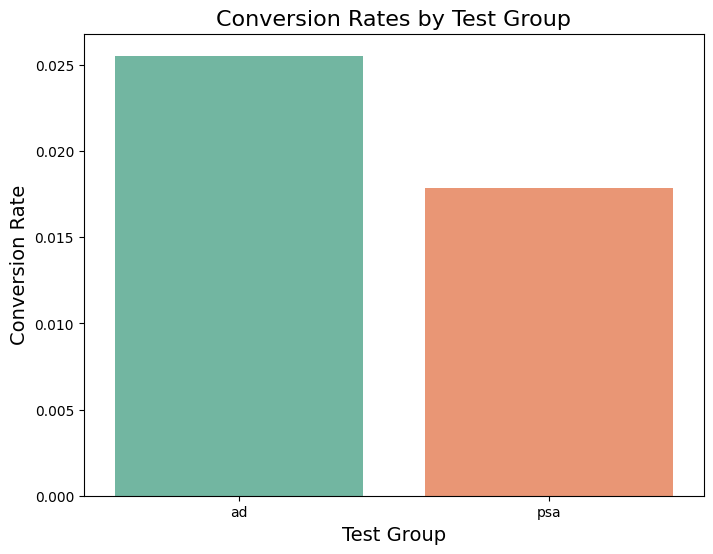

In [161]:
conversion_rate_by_group = data.groupby('test_group')['converted'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=conversion_rate_by_group.index, y=conversion_rate_by_group.values, palette="Set2")
plt.title('Conversion Rates by Test Group', fontsize=16)
plt.xlabel('Test Group', fontsize=14)
plt.ylabel('Conversion Rate', fontsize=14)
plt.show()

### Most Ads Day vs Conversion Rate

A bar plot comparing conversion rates across the different days of the week, segmented by test group. 

<Figure size 1000x600 with 0 Axes>

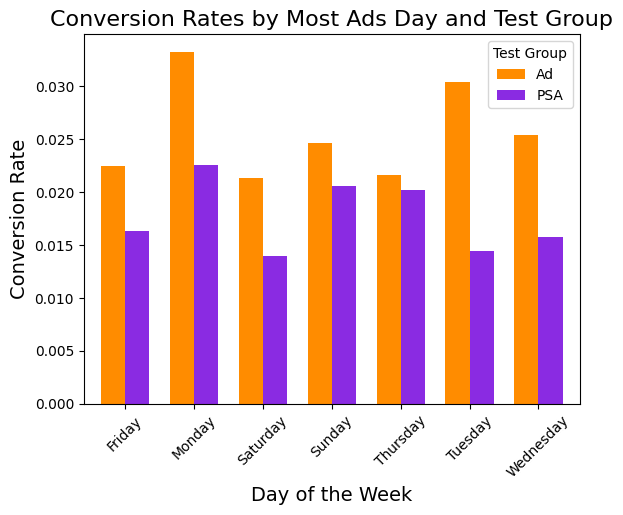

In [162]:
conversion_rate_by_day = data.groupby(['most_ads_day', 'test_group'])['converted'].mean().unstack()

plt.figure(figsize=(10, 6))
conversion_rate_by_day.plot(kind='bar', stacked=False, color=['#FF8C00', '#8A2BE2'], width=0.7)
plt.title('Conversion Rates by Most Ads Day and Test Group', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Conversion Rate', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Test Group', labels=['Ad', 'PSA'])
plt.show()

### Conversion Heatmap 

Showing conversion rates by most_ads_day and most_ads_hour.

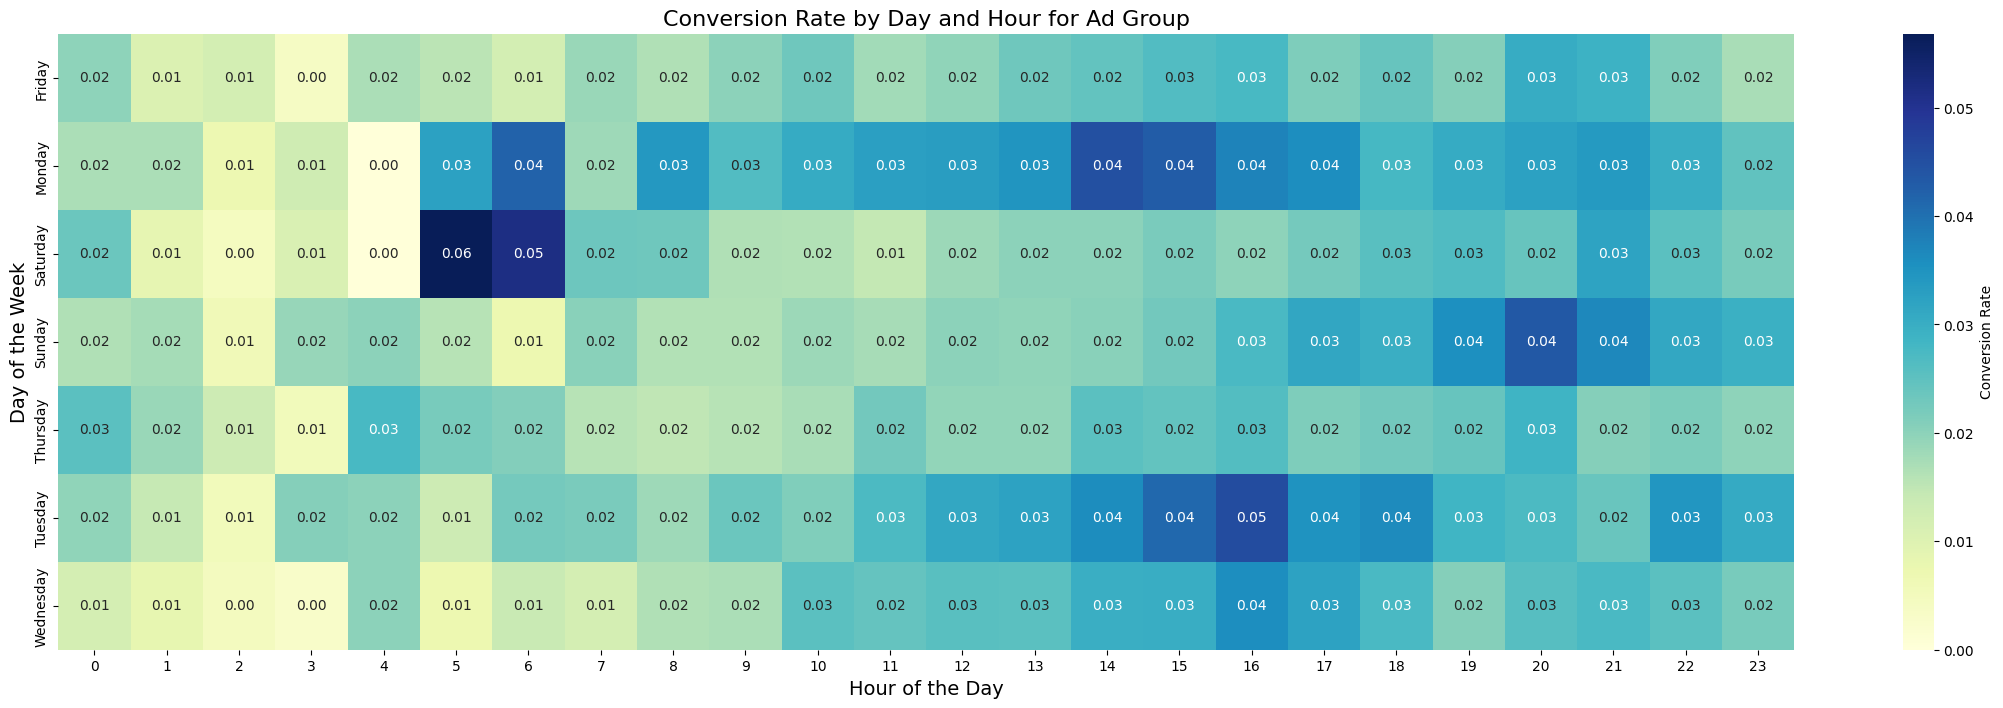

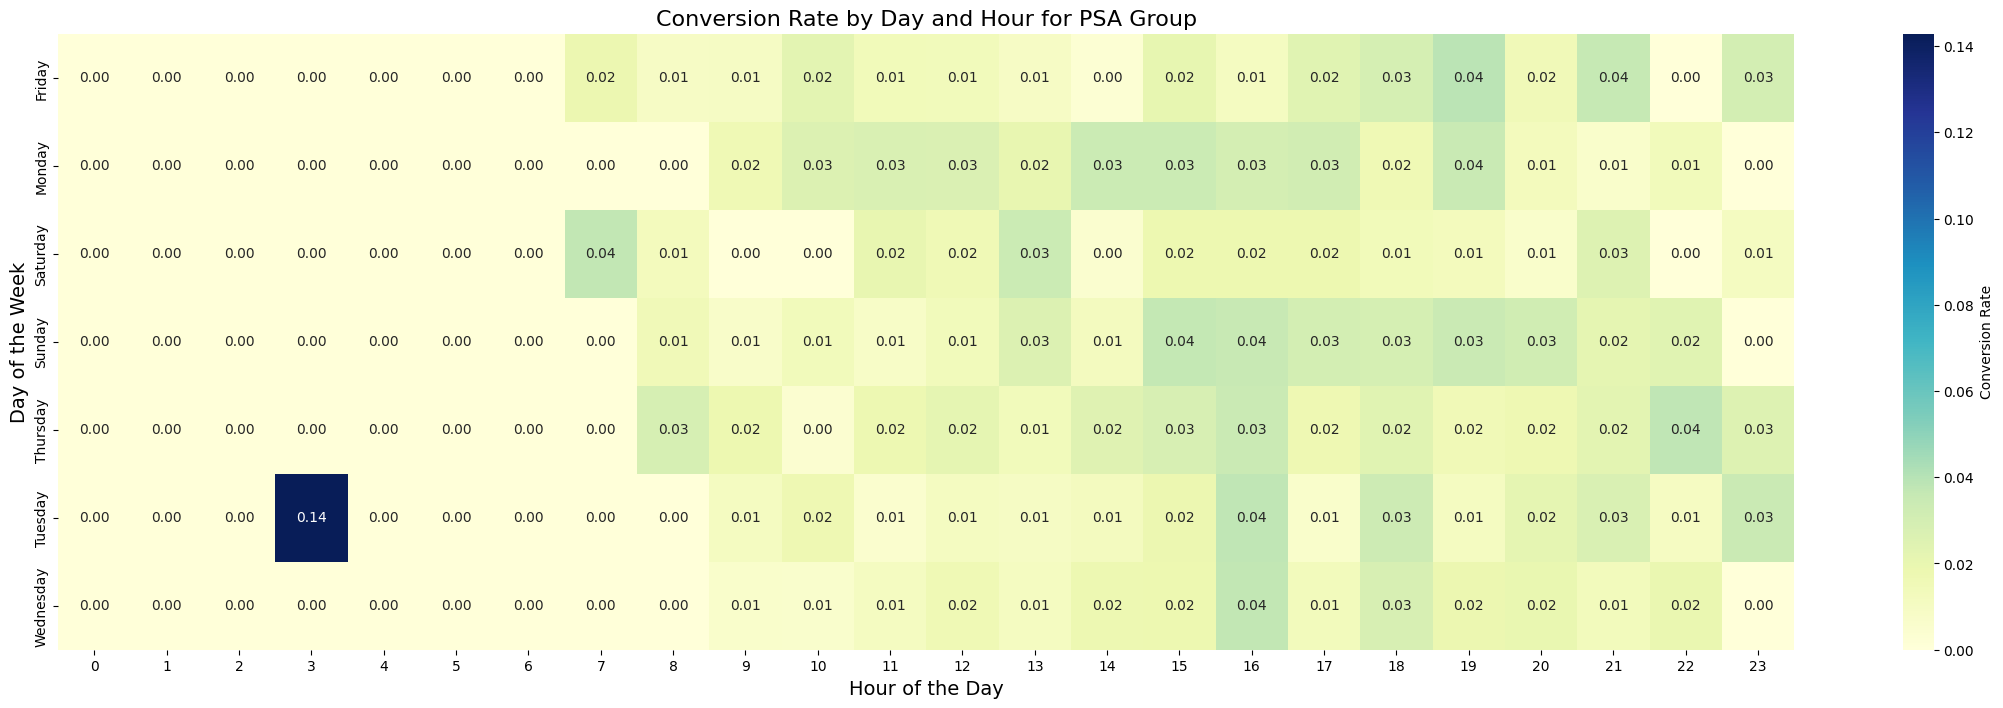

In [163]:
# Heatmap for "ad" group
ad_data = data[data['test_group'] == "ad"]

# Create a pivot table for "ad" group
ad_pivot = ad_data.pivot_table(values='converted', 
                               index='most_ads_day', 
                               columns='most_ads_hour', 
                               aggfunc='mean', 
                               observed=False)

# Check if pivot table is empty
if ad_pivot.empty:
    print("Warning: Ad group pivot table is empty.")
else:
    # Replace NaN values with 0
    ad_pivot.fillna(0, inplace=True)

    # Plot heatmap for "ad" group
    plt.figure(figsize=(28, 8))
    sns.heatmap(ad_pivot, cmap="YlGnBu", annot=True, fmt='.2f', cbar_kws={'label': 'Conversion Rate'})
    plt.title('Conversion Rate by Day and Hour for Ad Group', fontsize=16)
    plt.xlabel('Hour of the Day', fontsize=14)
    plt.ylabel('Day of the Week', fontsize=14)
    plt.show()

# Heatmap for "psa" group
psa_data = data[data['test_group'] == "psa"]

# Create a pivot table for "psa" group
psa_pivot = psa_data.pivot_table(values='converted', 
                                 index='most_ads_day', 
                                 columns='most_ads_hour', 
                                 aggfunc='mean', 
                                 observed=False)

# Check if pivot table is empty
if psa_pivot.empty:
    print("Warning: PSA group pivot table is empty.")
else:
    # Replace NaN values with 0
    psa_pivot.fillna(0, inplace=True)

    # Plot heatmap for "psa" group
    plt.figure(figsize=(28, 8))
    sns.heatmap(psa_pivot, cmap="YlGnBu", annot=True, fmt='.2f', cbar_kws={'label': 'Conversion Rate'})
    plt.title('Conversion Rate by Day and Hour for PSA Group', fontsize=16)
    plt.xlabel('Hour of the Day', fontsize=14)
    plt.ylabel('Day of the Week', fontsize=14)
    plt.show()